# Ejercicio 1

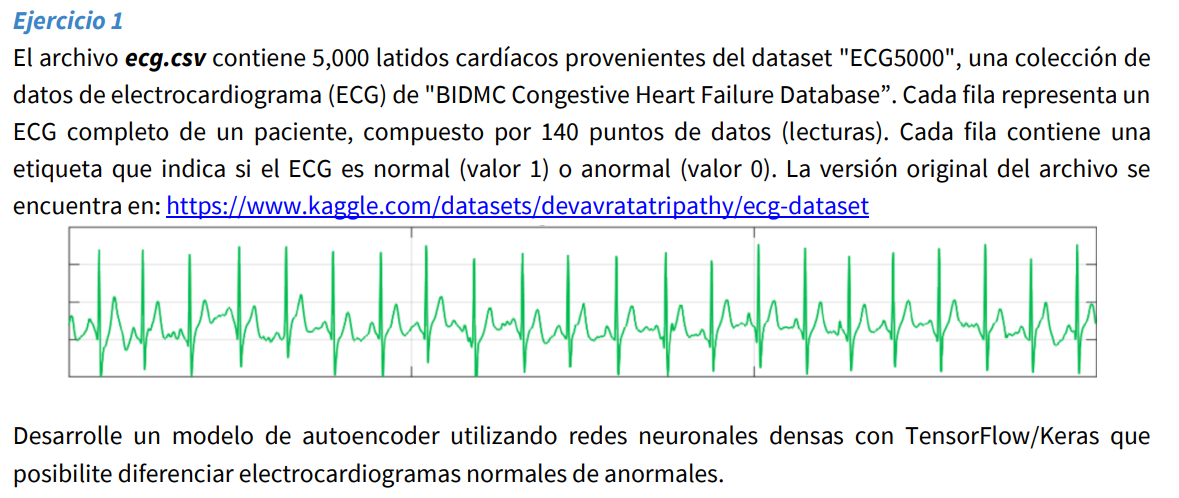

### Importe de librerias y lectura de datos

In [1]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [6]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos
import numpy as np

nombre_archivo = DATOS_DIR + 'ecg.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'], header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

### Preparacion de datos y normalizacion

In [7]:
#separo en x y en y
raw_data = df.values #se convierte en matriz
labels = raw_data[:, -1]    # Etiquetas (última columna)
data = raw_data[:, 0:-1]  # Datos (secuencia de 140 lecturas)

In [8]:
labels = labels.astype(int) # ajustas etiquetas porque tiene valores en punto flotante (0.0/1.0)

In [9]:
#separo los datos en train y test
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=1
)

In [10]:
# Normalización de datos entre 0 y 1. Los datos son lecturas de una señal acotada en intensidad
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [11]:
#los electrocardiogramas normales son los que valen 1
normal_train_data = train_data[train_labels == 1]
normal_test_data = test_data[test_labels == 1]
#los electrocardiogramas anormales son los que valen 0
anomal_train_data = train_data[train_labels == 0]
anomal_test_data = test_data[test_labels == 0]

### Grafico de ECG ANORMAL y ECG NORMAL

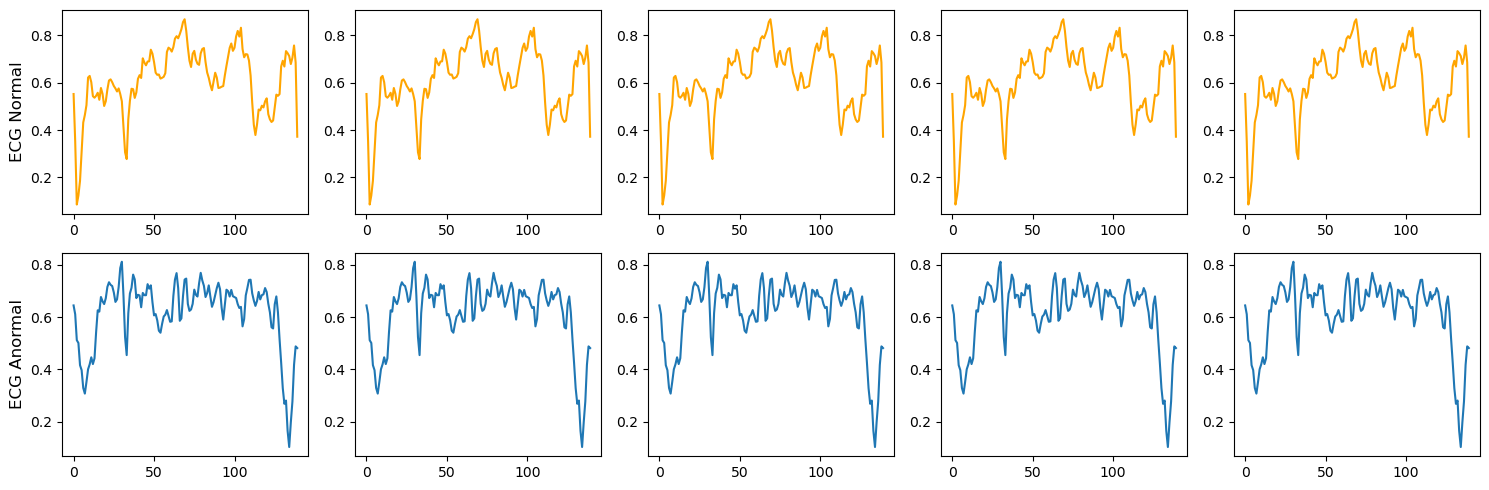

In [12]:
MOSTRAR = 5
FEAT_CNT = 140

fig, axs = plt.subplots(2, MOSTRAR, figsize=(15, 5))  # Ajusta el tamaño de la figura según sea necesario

for i in range(2):
    for j in range(MOSTRAR):
        if i == 0:
            axs[i, j].plot(np.arange(FEAT_CNT), normal_train_data[i], color='orange')  # Cambiar el color de la segunda fila a naranja
        else:
            axs[i, j].plot(np.arange(FEAT_CNT), anomal_train_data[i])  # Gráficos predeterminados para la primera fila

        #axs[i, j].spines['right'].set_visible(False)

# Agregar títulos
axs[0, 0].set_ylabel('ECG Normal' , fontsize=12)
axs[1, 0].set_ylabel('ECG Anormal', fontsize=12)

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficos
plt.show()

### Construccion del modelo

Hay que crear dos modelos, uno para el codificador y otro para el decodificador.

In [13]:
# codificador
encoder = tf.keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu")],
    name = 'Encoder'
    )

# decodificador
decoder = tf.keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(140, activation="sigmoid")],
    name = 'Decoder'
    )

In [15]:
# Modelo completo del autoencoder
inputs = tf.keras.Input(shape=(140,)) #capa de entrada
encoded = encoder(inputs) #al codificador le mando la capa de entrada
decoded = decoder(encoded) #al decodificador le mando el codificador

# Modelo que tiene dos modelos en secuencia
autoencoder = tf.keras.Model(inputs=inputs, outputs=decoded, name = 'Autoencoder')


In [16]:
#compilacion
autoencoder.compile(optimizer='adam', loss='mae')

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         4,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,176 (20.22 KB)

 Trainable params: 5,176 (20.22 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 140)            │         4,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,308 (20.73 KB)

 Trainable params: 5,308 (20.73 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Sequential)            │ (None, 8)              │         5,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ (None, 140)            │         5,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,484 (40.95 KB)

 Trainable params: 10,484 (40.95 KB)

 Non-trainable params: 0 (0.00 B)

None


### Entrenamiento

In [18]:
#entrenamiento
history = autoencoder.fit(normal_train_data, normal_train_data,
    epochs=60, batch_size=128, validation_data=(test_data, test_data),
    shuffle=True
    )

#este modelo se entrena con datos normales, por eso luego se mide el error que hay entre la reconstruccion y los datos


#el primer argumento normal_train_data es el conjunto de datos de entrada (input) para el autoencoder
#el segundo argumento normal_train_data tambien es el conjunto de etiquetas o targets que el autoencoder intenta reconstruir
#en un autoencoder los targets son iguales a los datos de entrada ya que el objetivo de la red es que aprenda a reconstruir los datos de la mejor manera posible

#lo mismo pasa con los datos de validacion

Epoch 1/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0318 - val_loss: 0.0528
Epoch 2/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318 - val_loss: 0.0524
Epoch 3/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315 - val_loss: 0.0521
Epoch 4/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312 - val_loss: 0.0515
Epoch 5/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309 - val_loss: 0.0516
Epoch 6/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302 - val_loss: 0.0514
Epoch 7/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0303 - val_loss: 0.0511
Epoch 8/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298 - val_loss: 0.0510
Epoch 9/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - val_loss: 0.0509
Epoch 10/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.0510
Epoch 11/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290 - val_loss: 0.0516
Epoch 12/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_lo

### Graficos extra

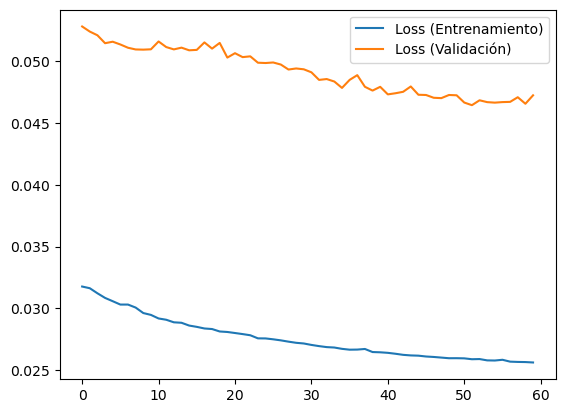

In [19]:
######## plot
plt.figure()
plt.plot(history.history["loss"], label="Loss (Entrenamiento)")
plt.plot(history.history["val_loss"], label="Loss (Validación)")
plt.legend()

Reconstruccion de ECG normal y anormal

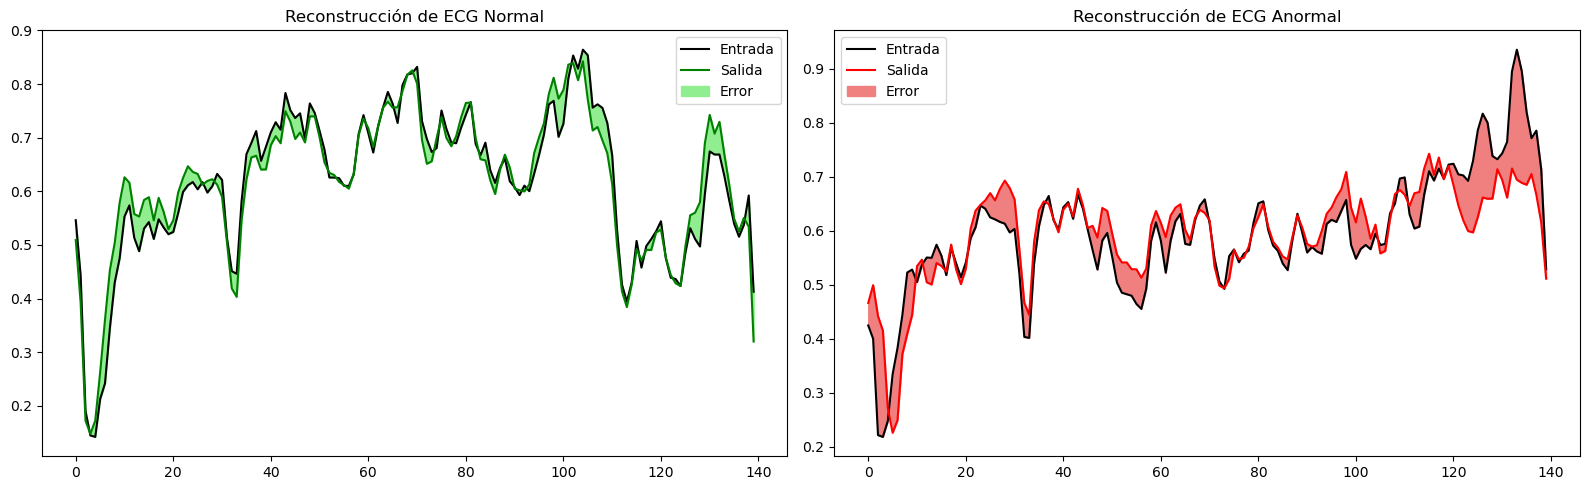

In [20]:
plt.figure(figsize=(16,5))

# Error de reconstrucción para ECG Normal
# decoded_data = autoencoder.predict(normal_test_data) # equivalente a lineas siguientes
encoded_data = encoder(normal_test_data).numpy()  # equivalente a encoded_data = encoder.predict(normal_test_data)
decoded_data = decoder(encoded_data).numpy()      # equivalente a decoded_data = decoder.predict(encoded_data)

plt.subplot(1, 2, 1)
plt.title("Reconstrucción de ECG Normal")
plt.plot(normal_test_data[0], 'black')
plt.plot(decoded_data[0], 'green')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightgreen')
plt.legend(labels=["Entrada", "Salida", "Error"])

# Error de reconstruccion para ECG Anormal
encoded_data = encoder(anomal_test_data).numpy()
decoded_data = decoder(encoded_data).numpy()

plt.subplot(1, 2, 2)
plt.title("Reconstrucción de ECG Anormal")
plt.plot(anomal_test_data[0], 'black')
plt.plot(decoded_data[0], 'red')
plt.fill_between(np.arange(140), decoded_data[0], anomal_test_data[0], color='lightcoral')
plt.legend(labels=["Entrada", "Salida", "Error"])

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficos
plt.show()

 Error de reconstruccion en ECG normales en el conjunto de entrenamiento

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


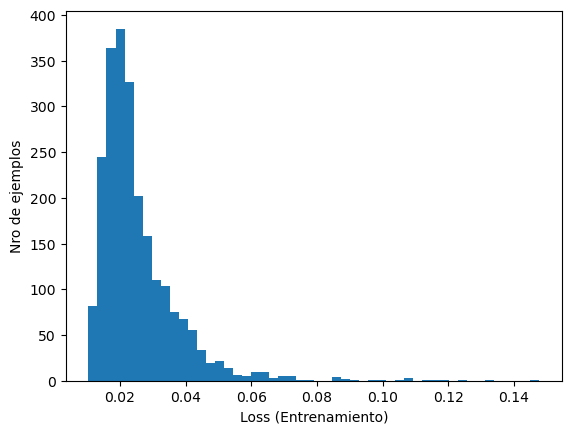

In [21]:
#Trazar el error de reconstrucción en ECG normales del conjunto de entrenamiento
reconstruccion = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstruccion, normal_train_data)

plt.figure()
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Loss (Entrenamiento)")
plt.ylabel("Nro de ejemplos")
plt.show()

Error de reconstruccion en ECG anormales del conjunto de prueba

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


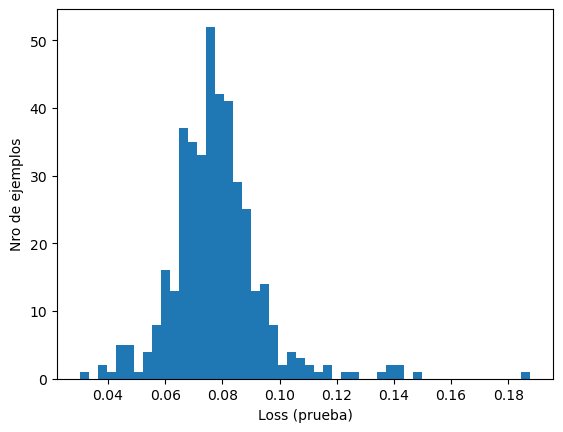

In [22]:
reconstruccion = autoencoder.predict(anomal_test_data) #reconstruyo los datos pasados como entrada
test_loss = tf.keras.losses.mae(reconstruccion, anomal_test_data) #mido q tan diferente es la reconstruccion respecto a los datos originales de entrenamiento

#grafico
plt.figure()
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Loss (prueba)")
plt.ylabel("Nro de ejemplos")
plt.show()




In [23]:
#PREDICCION
def predict(modelo, datos, umbral): #modelo entrenado, datos a evaluar si son normales o anomalos, umbral para decidir normal o anormal
  reconstruccion = modelo(datos) #reconstruyo los datos pasados como entrada, es lo mismo q hacer predict
  loss = tf.keras.losses.mae(reconstruccion, datos) #calculo error de reconstruccion
  return tf.math.less(loss, umbral) #compara con el error y determina si es NORMAL o ANORMAL
#si el error es grande quiere decir que es anormal
#si el error es chico quiere decir que es normal
#esto es porque el modelo fue entrenado con datos normales, entonces si el error es grande es porque los datos no coinciden con los entrenados


#METRICAS
def print_stats(predicciones, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predicciones)))
  print("Precision = {}".format(precision_score(labels, predicciones)))
  print("Recall = {}".format(recall_score(labels, predicciones)))


#DEFINICION DE UMBRAL (para determinar si es normal o no)
# Elija un valor de umbral que sea una desviación estándar por encima de la media.
#threshold = np.mean(train_loss) + np.std(train_loss)
umbral = np.mean(train_loss) + 1.5*np.std(train_loss)
print("Umbral: ", umbral)

# Al examinar el error de reconstrucción de los ejemplos anómalos en el conjunto de prueba, se observa
# que la mayoría tiene un error de reconstrucción mayor que el umbral. Al variar el umbral, puede
# ajustar la "precision" y el "recall".

# evalua los datos de prueba con las reconstrucciones, mide error y aplica umbral
preds = predict(autoencoder, test_data, umbral)
# imprime estadisticas en función del umbral aplicado
print_stats(preds, test_labels)

Umbral:  0.04445433055305109
Accuracy = 0.952
Precision = 0.9892086330935251
Recall = 0.9290540540540541


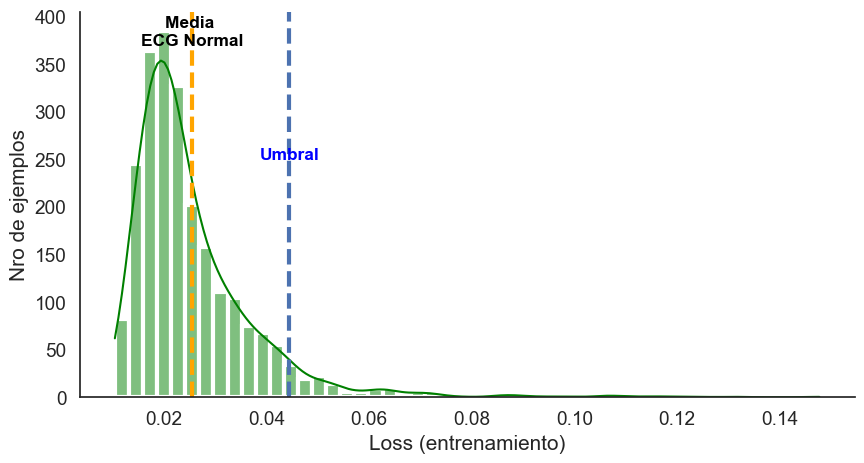

In [24]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.25)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='green',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='orange', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 370, "Media \nECG Normal", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=umbral, color='b', linestyle='--', linewidth=3)
plt.text(umbral, 250, "Umbral", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')
plt.xlabel("Loss (entrenamiento)")
plt.ylabel("Nro de ejemplos")
sns.despine()

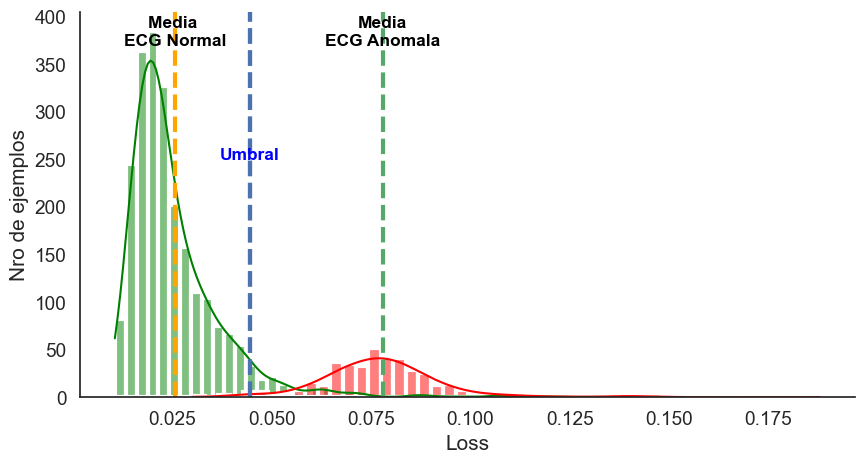

In [25]:
plt.figure(figsize=(10,5))
sns.set(font_scale = 1.25)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='green',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='orange', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 370, "Media \nECG Normal", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=umbral, color='b', linestyle='--', linewidth=3)
plt.text(umbral, 250, "Umbral", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 370, "Media\nECG Anomala", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=umbral, color='b', linestyle='--', linewidth=3)
plt.xlabel("Loss")
plt.ylabel("Nro de ejemplos")
sns.despine()